# Project Introduction - Customer Segmentation (Part 3)
The goal of this project is to analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population with the aim of understanding which segment of the population the company should aim for in its next mail campaign. 

The project is divided into __three main parts__:
1. The first part will be decicated to the data preparation: This data is high-dimensional and has a high degree of missing values, therefore it is important to understand and clean the data.
2. In this section the customers will be segmented using a __unsupervised learning approach__ and using the customer's data against the general population's data. Not only is the goal to understand which groups of customers are more interesting for the campaign but also to select the most important features.
3. Using the information gained a __supervised learning algorithm__ will be used for a classification task to predict which recipients are most likely to become a customer for the mail-order company.

__Note__: This notebook handles part 3. The first part of the data cleaning process can be found in this notebook [here](https://github.com/bruno-f7s/portfolio/blob/main/arvarto-customer-segmentation/01-data-cleaning.ipynb).

In [1]:
# import libraries
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from joblib import dump, load

# magic word for producing visualizations in notebook
%matplotlib inline

# configurations
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.set_option('display.max_colwidth', None)

# PART 3: Customer Segmentation (Supervised Learning)
In this section we will use different models to train a model that predicts whether a given individual is going to be a customer or not. We will use the Mailout dataset which includes the target variable to build and test the model and at the end we will use the second dataset without the target variable to see how many individuals our customers would likely be.

We will expand what we did in the second part by using the same scaler and dimensionality reduction's model to apply onto these datasets. Furthermore, we will also use the same clusters from the previous section as a new variable to add to the data. At the end, once we are applying the model onto the new data, we can analyze if the clusters which have been determined as the target groups have more positive predictions than the others.

The approach looks like this:
1.	Brief exploratory data analysis of the distributions of the target variable.
2.	Split the data into train and test sets.
3.  Build a ml pipeline to try different models.
4.  Evaluate the performance and chose a model.
5.  Refit the best model onto the whole dataset.
6.  Predict on the new data (data without the target variable).
7.  Finalize with an analysis of the results.

In [2]:
# Load the cleaned data for the customer segmentation part
train_df = pd.read_csv('data\\Cleaned_Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
test_df = pd.read_csv('data\\Cleaned_Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [3]:
train_df.shape

(34508, 345)

In [4]:
test_df.shape

(34499, 344)

# 1. Target Variable Analysis

Percentage of 0s: 98.7%
Percentage of 1s: 1.3%


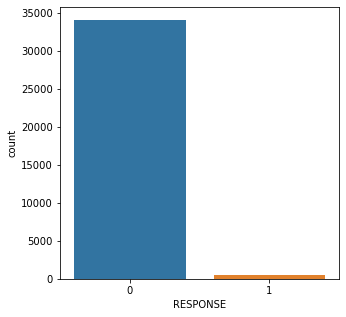

In [5]:
# Plot the counts for the reponse variable
plt.figure(figsize = (5, 5))
sns.countplot(data = train_df, x='RESPONSE')

print(f"Percentage of 0s: {round((len(train_df[train_df['RESPONSE'] == 0]) / len(train_df['RESPONSE']))*100, 1)}%")
print(f"Percentage of 1s: {round((len(train_df[train_df['RESPONSE'] == 1]) / len(train_df['RESPONSE']))*100, 1)}%")

__Observation__: This dataset is extremely imbalanced. There are several ways to try and tackle this problem like undersampling the label 0 or oversampling the label 1. Between both, oversampling the label 1 would be preferable since we are not losing any information with this.

In this case I will try to overcome this problem by applying more weight to the 1 class during model training and try to use a stratified cross-validation approach, which can be beneficial when dealing with imbalanced classes when comparing to the standard approach. If anything works well, then another try could be some oversampling method.

#### Analyse the label distribution per cluster

In [6]:
# separate the target from the rest so it can be fed into the previous models
train_df_wo_target = train_df.drop(["RESPONSE"], axis=1)
train_df_target  = train_df["RESPONSE"]

In [7]:
# load the scaler, pca and kmeans models
loaded_sc = load('models\\population_scaler.joblib')
loaded_pca = load('models\\population_pca.joblib')
loaded_clusterer = load('models\\population_clusterer.joblib')

In [8]:
# Transform the data using the previous models
scaled_train_df_wo_target = loaded_sc.transform(train_df_wo_target)
pca_train_df_wo_target = loaded_pca.transform(scaled_train_df_wo_target)
clusters_train_df_wo_target = loaded_clusterer.predict(pca_train_df_wo_target)

In [9]:
# Join the clusters to the scaled data and add the target variable to it
temp_train_df = np.hstack((pca_train_df_wo_target, clusters_train_df_wo_target.reshape(-1, 1)))
temp_train_df = pd.DataFrame(temp_train_df)
temp_train_df = pd.concat([temp_train_df[temp_train_df.columns[-1:]], train_df_target], axis=1)
temp_train_df = temp_train_df.rename({157: "CLUSTER"}, axis=1)
temp_train_df["CLUSTER"] = temp_train_df["CLUSTER"] + 1
temp_train_df.head()

,CLUSTER,RESPONSE
0,4.0,0
1,2.0,0
2,2.0,0
3,4.0,0
4,4.0,0


In [10]:
# Compute Number of 0s and 1s per cluster
count_per_category = temp_train_df.groupby(['CLUSTER', 'RESPONSE']).size().reset_index(name='COUNT')

# Compute total counts per cluster
cluster_totals = count_per_category.groupby('CLUSTER')['COUNT'].sum().reset_index(name='TOTAL_PER_CLUSTER')

# Merge total counts with original dataframe
count_per_category = count_per_category.merge(cluster_totals, on='CLUSTER', how='left')

# Calculate the proportion of 0s and 1s per cluster
count_per_category['PROPORTION'] = round(count_per_category['COUNT'] / count_per_category['TOTAL_PER_CLUSTER'] *100, 1)
count_per_category = count_per_category.drop("TOTAL_PER_CLUSTER", axis=1)
count_per_category

,CLUSTER,RESPONSE,COUNT,PROPORTION
0,1.0,0,1096,98.3
1,1.0,1,19,1.7
2,2.0,0,14709,98.9
3,2.0,1,165,1.1
4,3.0,0,7772,98.9
5,3.0,1,88,1.1
6,4.0,0,10495,98.5
7,4.0,1,164,1.5


__Analysis__: We can see that the distribution of the 1 class follows a similar pattern across all clusters comparing to the whole data. 

In the previous part of the project, namely the customer segmentation, we saw that `cluster 4` should be the aim of the company's marketing efforts and when we look at the proportions of the 1 label in `cluster 4`, we see that it has a slightly higher proportion than `cluster 2` for instance - which is one where the customers are underrepresented comparing to the population. Altough the absolute numbers are not that high to be more sure, this is however an interesting fact towards the marketing strategy. 

What we can also do now is use the cluster labels as a new feature as well for the model fitting part. However we cannot just simply add it to the pca components, we first also need to scale it. 

# 2. Train-Test Split
For this part I will just to a train-test split and not a train-test-hold-out split because the dataset is not too big, so we would have few data to do all the steps.

In [11]:
# set up a seed to be used across the pipeline
seed = 101

In [12]:
# create X and y variables
X = train_df.drop(["RESPONSE"], axis=1)
y = train_df["RESPONSE"]

In [13]:
# load the scaler, pca and kmeans models
loaded_sc = load('models\\population_scaler.joblib')
loaded_pca = load('models\\population_pca.joblib')
loaded_clusterer = load('models\\population_clusterer.joblib')

In [14]:
# Transform the data using the previous models
scaled_X = loaded_sc.transform(X)
pca_X = loaded_pca.transform(scaled_X)
clusters = loaded_clusterer.predict(pca_X)

In [15]:
# Scale the clusters to add them to the scaled_X
cluster_scaler = StandardScaler()
scaled_clusters = cluster_scaler.fit_transform(clusters.reshape(-1, 1))

# Add the scaled clusters to the scaled_X
scaled_X = np.hstack((pca_X, scaled_clusters))

In [16]:
scaled_X.shape

(34508, 158)

In [17]:
# create the train and test splits
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.25, random_state=seed)

In [18]:
# Verify that the splits have the same label distribution
print("y_train")
print(f"Percentage of 0s: {round((len(y_train[y_train == 0]) / len(y_train))*100, 1)}%")
print(f"Percentage of 1s: {round((len(y_train[y_train == 1]) / len(y_train))*100, 1)}%")
print("-----------------------------------")
print("y_test")
print(f"Percentage of 0s: {round((len(y_test[y_test == 0]) / len(y_test))*100, 1)}%")
print(f"Percentage of 1s: {round((len(y_test[y_test == 1]) / len(y_test))*100, 1)}%")

y_train
Percentage of 0s: 98.7%
Percentage of 1s: 1.3%
-----------------------------------
y_test
Percentage of 0s: 98.7%
Percentage of 1s: 1.3%


# 3. ML Pipeline

In [19]:
def predict_and_test_model(model, X_train, X_test, y_train, y_test, cv, refit_metric, seed):
    """
    DESCRIPTION
    -----------
    This function can be used to train and test a model for a classification problem with one target variable.
    It uses cross-validation and grid search with the model GridSearchCV.
    No model gets returned, but rather metric results are printed out.
   
    PARAMETERS:
    -----------
        model (dictionray): A dictionary with the 3 elements: model of the name, model object and the parameter space.
            Example: {"name": "Logistic Regression",
                      "model": LogisticRegression(),
                      "param_search_space": {'penalty': ['elasticnet'],
                                            'l1_ratio': [0, 0.5, 1], 
                                                   'C': [1, 10, 25, 50, 100],
                                              'solver': ['saga'],
                                        'class_weight': ['balanced'],
                                        'random_state': [seed],
                                            'max_iter': [100, 200, 300, 500, 1000],
                                              'n_jobs': [-1]
                                            }
                     } 
                      
        X_train (dataframe): A dataframe with the train data of the features.
        X_test (dataframe): A dataframe with the test data of the features.
        y_train (dataframe): A dataframe with the train data of the target variable.
        y_test (dataframe): A dataframe with the test data of the target variable.
        cv (integer): The number of cross-validation folds
        refit_metric (string): The metric to be used to calculate the best model
        seed (integer): A value for the random_state
    """
    start_time = datetime.now()
            
    # Define the scoring metrics
    scorers = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=1),
    'roc_auc': make_scorer(recall_score, average='weighted', zero_division=1),
    'f1': make_scorer(f1_score, average='weighted', zero_division=1)
    }

    # Model Training
    #####################################
    print(f"Training the model {model['name']} using GridSearchCV...")
    
    # Build a grid search with cross-validation using BayesSearchCV
    grid_search = GridSearchCV(estimator=model["model"], 
                               param_grid=model["param_grid"], 
                               cv=StratifiedKFold(n_splits=cv, random_state=seed, shuffle=True), 
                               scoring=scorers, 
                               return_train_score=True,
                               refit=refit_metric,
                               verbose=1)
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Model Testing
    #####################################  
    # Predict on the test set
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:,1]
    
    # Get test metrics
    accuracy = (y_test == y_pred).mean()
    best_model = grid_search.best_estimator_
    cv_results = pd.DataFrame.from_dict(grid_search.cv_results_)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Print Results
    #####################################  
    
    # Print the overview results
    print(f"Model: {model['name']}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Overall Accuracy: {accuracy}")
    cv_results.head(len(cv_results))
    print("----------------------------------------------------------------")
        
    # Plot the ROC curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.tick_params(axis='both', labelsize=10)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    print("----------------------------------------------------------------")

    # PLot the confusion matrix
    plt.figure(figsize=(8,6))
    plt.title("Confusion Matrix", fontsize=14)
    sns.set(font_scale=1)
    heatmap = sns.heatmap(cm, annot=True)
    heatmap.set_xlabel("Predicted label", fontsize=12)
    heatmap.set_ylabel("True label", fontsize=12)
    heatmap.tick_params(axis='both', labelsize=10)
    plt.show()
    print("----------------------------------------------------------------")
    
    # Print the classication report
    print(classification_report(y_test, y_pred, zero_division=1))
    print("----------------------------------------------------------------")

    end_time = datetime.now()
    print(f"Training time: {str(end_time - start_time)}")    

# 4. Model testing

### Logistic Regression

In [20]:
lr = {"name": "Logistic Regression",
      "model": LogisticRegression(),
      "param_grid": {
          'penalty': ['elasticnet'],
          'l1_ratio': [0, 0.5, 1], 
          'C': [1, 10, 50, 100],
          'solver': ['saga'],
          'class_weight': ['balanced'],
          'random_state': [seed],
          'max_iter': [100, 1000, 5000],
          'n_jobs': [-1]}
     }

In [ ]:
predict_and_test_model(lr, X_train, X_test, y_train, y_test, 5, "f1", seed)

Training the model Logistic Regression using GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: Con

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: Con

### Random Forest
__Observation:__ If computational power is not an issue then this can be replaced with GradientBoostingClassifier().

In [ ]:
# define weights for the 1 and 0 classes
rfc = {
    "name": "Gradient Boosting",
    "model": RandomForestClassifier(),
    "param_grid": {
        'n_estimators': [100, 250, 500, 1000], 
        'max_depth': [None, 3, 5, 7],
        'max_features': [None, 'sqrt', 'log2'],
        'class_weight': ['balanced_subsample'],
        'random_state': [seed],
        'n_jobs': [-1]
    } 
}

In [ ]:
predict_and_test_model(rfc, X_train, X_test, y_train, y_test, 5, "f1", seed)

### XGBoost 

In [ ]:
xgbc = {
    "name": "XGBoost",
    "model": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), # To prevent a warning related to label encoding
    "param_grid": {
        'n_estimators': [50, 100, 150, 200, 500], 
        'learning_rate': [0.01, 0.1, 1], 
        'max_depth': [3, 5, 7, 9],
        'alpha':[0.1, 0.25, 0.5, 0.75],
        'subsample': [None, 0.1, 0.5, 1],
        'random_state': [seed]
    } 
}

In [ ]:
predict_and_test_model(xgbc, X_train, X_test, y_train, y_test, 5, "f1", seed)

__Analysis__:

# 5. Fit the best model

# 6. Predict on the new data

# 7. Analysis of the results

In [ ]:
#inversed_X = sc.inverse_transform(pca.inverse_transform(pca_scaled_X[:, :-1]))

In [ ]:
#inversed_clusters = cluster_scaler.inverse_transform(pca_scaled_X[:, -1].reshape(-1, 1))